In [1]:
import os
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import average_precision_score

np.random.seed(2019)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import lightgbm as lgb

In [2]:
base_path = os.path.abspath('../..')
data_path = os.path.join(base_path, 'data')
database_path = os.path.join(data_path, 'database')
strategy_path = os.path.join(base_path, 'strategy')
sys.path.append(strategy_path)

In [3]:
from strategy import CommodityStrategy, EquityStrategy, IRStrategy, EmergingStrategy
from tester import Tester

In [4]:
from models.CRNN import CRNN_model

# 1. Data

In [5]:
strategy = EmergingStrategy(strategy_name="EMPM", asset_type="EMERGiNG")
strategy.load_index_and_return(from_db=False, save_file=False)

strategy.index.columns.name = 'ticker'
strategy.ret.columns.name = 'ticker'

strategy.index.index.name = 'tdate'
strategy.ret.index.name = 'tdate'
strategy.ret.loc['2013-01-02'] = strategy.ret.loc['2013-01-03']

strategy.index.drop_duplicates(inplace=True)
strategy.ret.drop_duplicates(inplace=True)

2019-10-31 09:36:01,036 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:36:01,038 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:36:01,039 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [6]:
df_index = strategy.index.loc[:'2019-07']
df_index_return = strategy.ret.loc[:'2019-07']

# 2. Explore

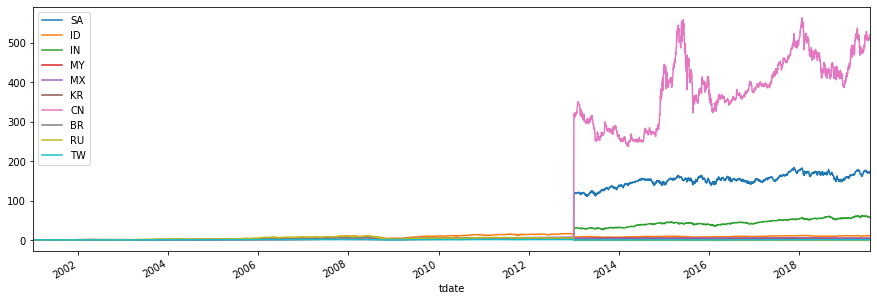

In [7]:
plt.figure(figsize=(15,5))
for column in df_index.columns:
    df_index[column].plot()
plt.legend()

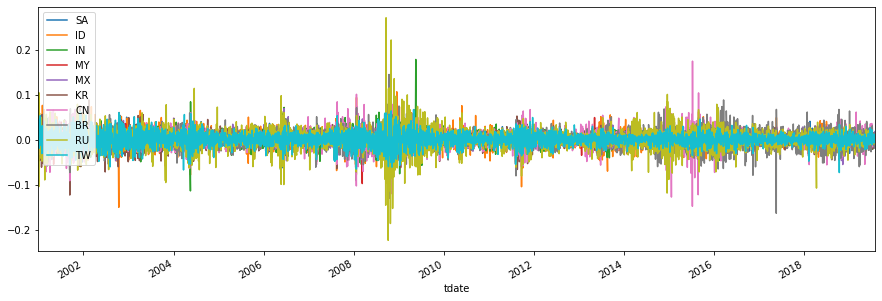

In [8]:
plt.figure(figsize=(15,5))
for column in df_index_return.columns:
    df_index_return[column].plot()
plt.legend()

# 3. Model

### CROSS SECTIONAL

In [9]:
indiv_momentum_lst =[1, 2, 3, 4, 5, 10, 21, 42, 63]

## 1. X

### moving average 와 주가 차이

In [10]:
moving_avg = {}

for i, period in enumerate(indiv_momentum_lst):
    moving_avg['moving_average_' + str(period)] = df_index.rolling(period).mean() - df_index

### moving average  ratio

In [11]:
moving_avg_ratio = {}
moving_avg_ratio_diff = {}

for i, period in enumerate(indiv_momentum_lst):
    moving_avg_ratio['moving_average_ratio_' + str(period)] = df_index.rolling(period).mean() / df_index
    moving_avg_ratio_diff['moving_average_ratio_diff_' + str(period)] = moving_avg_ratio['moving_average_ratio_' + str(period)].diff(period)

In [12]:
df_moving_avg = pd.concat(moving_avg, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_moving_avg_ratio = pd.concat(moving_avg_ratio, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_moving_avg_ratio_diff = pd.concat(moving_avg_ratio_diff, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]

### moving average ratio 간 차이

In [13]:
moving_avg_columns = df_moving_avg_ratio.columns

for i, column1 in enumerate(moving_avg_columns[1:]):
    for j, column2 in enumerate(moving_avg_columns[2+i:]):
        df_moving_avg_ratio[column2 + " - " + column1] = df_moving_avg_ratio[column1] - df_moving_avg_ratio[column2]

# CASE 0. 기존

<img src="./result/EMPM_PAST.png">

<img src="./result/EMPM.png">

- 빨간색이 CROSS SECTIONAL 임

# CASE 1. BINARY

- Binary로 나누어서 학습하고 상위 30% 하위 30% 롱숏

In [14]:
one_week = 5
one_month = 20

In [15]:
df_index_rank = df_index.pct_change(one_week).shift(-1 * one_week).rank(axis=1) 

### binary - 50%

In [16]:
df_index_y_binary = df_index_rank > df_index_rank.shape[1] / 2
df_index_y_binary = df_index_y_binary.astype(np.float32)

In [17]:
df_y = df_index_y_binary.unstack().reset_index()
df_y = df_y.set_index('tdate').loc['1994':]
df_y.columns = ['ticker', 'y']

In [18]:
df_moving_avg.reset_index(inplace=True)
df_moving_avg_ratio.reset_index(inplace=True)

df_join = pd.merge(df_y, df_moving_avg, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_moving_avg_ratio, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_moving_avg_ratio_diff, on=['tdate', 'ticker'])

In [19]:
df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime('2010-12-31')]
df_val = df_join.loc[(df_join['tdate'] >= pd.to_datetime('2009-01-01')) & (df_join['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[3:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [20]:
def train(train_x, train_y1, val_x, val_y1, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': 3,
          'num_leaves': 25,
          "learning_rate": learning_rate,
          "feature_fraction": 0.8,
          "subsample": 0.8,
          "verbosity": 1,
          "metric": 'binary_logloss'
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [21]:
lgb_models = []
lgb_train_pred1 = []
lgb_val_pred1 = []

model, train_pred, val_pred = train(df_train_x.values, df_train_y.values, df_train_x.values, df_train_y.values, 
                                    num_boost_round=500, 
                                    learning_rate=0.01, 
                                    verbose=10,
                                    early_stopping_rounds=500)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.692394	valid_1's binary_logloss: 0.692394
[20]	training's binary_logloss: 0.691754	valid_1's binary_logloss: 0.691754
[30]	training's binary_logloss: 0.691177	valid_1's binary_logloss: 0.691177
[40]	training's binary_logloss: 0.690668	valid_1's binary_logloss: 0.690668
[50]	training's binary_logloss: 0.690163	valid_1's binary_logloss: 0.690163
[60]	training's binary_logloss: 0.689697	valid_1's binary_logloss: 0.689697
[70]	training's binary_logloss: 0.689246	valid_1's binary_logloss: 0.689246
[80]	training's binary_logloss: 0.688826	valid_1's binary_logloss: 0.688826
[90]	training's binary_logloss: 0.688436	valid_1's binary_logloss: 0.688436
[100]	training's binary_logloss: 0.688055	valid_1's binary_logloss: 0.688055
[110]	training's binary_logloss: 0.687662	valid_1's binary_logloss: 0.687662
[120]	training's binary_logloss: 0.687282	valid_1's binary_logloss: 0.687282
[130]	training's binary

In [22]:
test_pred = model.predict(df_test_x.values)

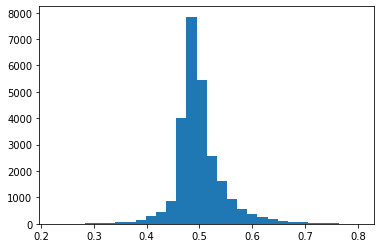

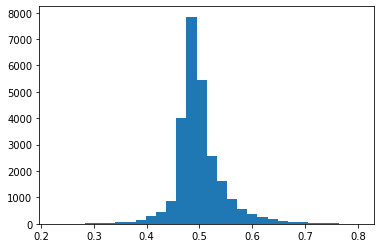

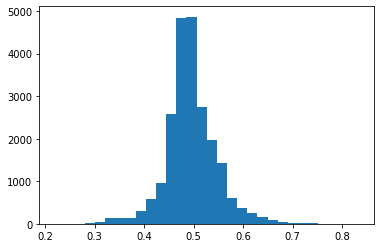

In [23]:
plt.hist(train_pred, bins=30)
plt.show()

plt.hist(val_pred, bins=30)
plt.show()

plt.hist(test_pred, bins=30)
plt.show()

### 결과

In [24]:
df_train['y_pred'] = train_pred
df_test['y_pred'] = test_pred

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
df_train_pred = pd.pivot_table(df_train, columns='ticker', index='tdate', values='y_pred')
df_test_pred = pd.pivot_table(df_test, columns='ticker', index='tdate', values='y_pred')

In [26]:
df_pred = pd.concat([df_train_pred, df_test_pred], axis=0)

In [27]:
df_index_sub = df_index.loc['1994':]

In [28]:
long = df_pred.shape[1] / 10 * 7
short = df_pred.shape[1] / 10 * 3

df_pred_rank = df_pred.rank(axis=1)
df_pred_long = (df_pred_rank > long).astype(np.float32)
df_pred_short = (df_pred_rank < short).astype(np.float32)
df_pred_long_short = df_pred_long - df_pred_short

In [29]:
strategy.TSRV = df_pred_long_short
strategy.CSRV = df_pred_long_short

In [30]:
strategy.set_rebalance_period(freq='week', rebalance_weekday=1) 

2019-10-31 09:36:03,564 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD


In [31]:
tester = Tester(strategy)

In [32]:
tsrv_cum_return, tsrv_summary = tester.test_ts_signal()
csrv_cum_return, csrv_summary = tester.test_cs_signal()

C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:29: RuntimeWarning: divide by zero encountered in true_divide
  tsrv_port = pd.DataFrame(tsrv_sig.to_numpy() / tsrv_sig.sum(axis=1).values.reshape(-1, 1), columns=tsrv_sig.columns, index=tsrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:29: RuntimeWarning: invalid value encountered in true_divide
  tsrv_port = pd.DataFrame(tsrv_sig.to_numpy() / tsrv_sig.sum(axis=1).values.reshape(-1, 1), columns=tsrv_sig.columns, index=tsrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:39: RuntimeWarning: divide by zero encountered in true_divide
  csrv_port = pd.DataFrame(csrv_sig.to_numpy() / csrv_sig.sum(axis=1).values.reshape(-1, 1), columns=csrv_sig.columns, index=csrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:39: RuntimeWarning: invalid value encountered in

In [33]:
strategy.set_portfolio_parameter(cs_strategy_type='notional')
strategy.make_portfolio()

2019-10-31 09:36:03,613 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:36:03,613 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:36:03,614 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:36:10,477 - EMPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-31 09:36:10,478 - EMPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-31 09:36:11,647 - EMPM - INFO - [STEP 5 - 2 - 2] TARGET VOL CONTROL to TS POSITION
2019-10-31 09:36:11,653 - EMPM - INFO - [STEP 5 - 2 - 3] STRATEGY LEVEL VOL CONTROL to TS POSITION
2019-10-31 09:36:12,450 - EMPM - INFO - [STEP 5 - 2 - 4] MAKE FINAL TS POSITION
2019-10-31 09:36:12,452 - EMPM - INFO - [STEP 5 - 3] MAKE CS POSITION
2019-10-31 09:36:12,453 - EMPM - INFO - [STEP 5 - 3 - 1] NO TARGET VOL CONTROL to CS POSITION
2019-10-31 09:36:12,453 - EMPM - INFO - [STEP 5 - 3 - 2] ALIGN CS POSITION WITH REBALANCE DAY
2019-10-31 09:36:17,848 - EMPM - INFO - [STEP 5 - 3 - 3] STRATEGY LEVEL VOL CONTROL to CS POSITIO

### TRAIN

2019-10-31 09:36:18,772 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:36:18,773 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:36:18,779 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-31 09:36:18,785 - EMPM - INFO - [STEP 7] PLOT BACKTEST RESULT


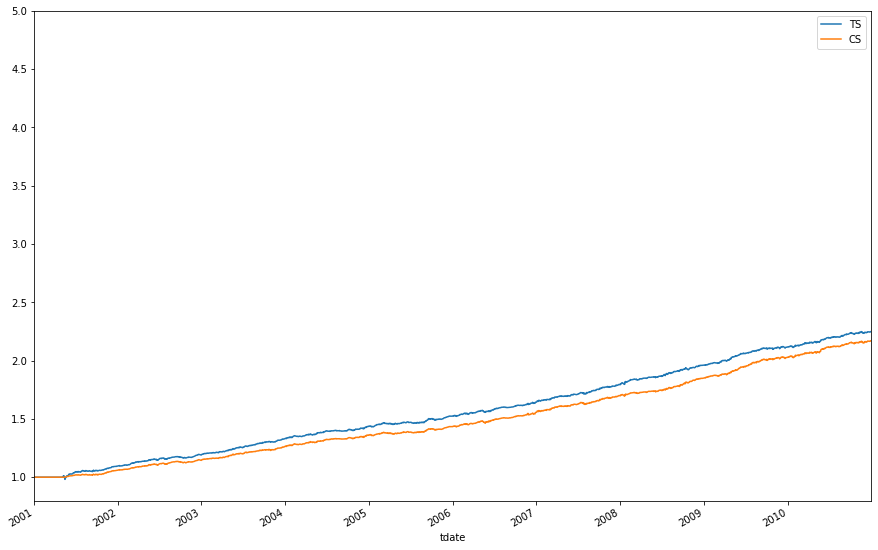

In [34]:
tester = Tester(strategy)
tester.set_period(start='1994-01-01', end='2010-12-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.8, 5))

### TEST

2019-10-31 09:36:18,932 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:36:18,932 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:36:18,937 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-31 09:36:18,943 - EMPM - INFO - [STEP 7] PLOT BACKTEST RESULT


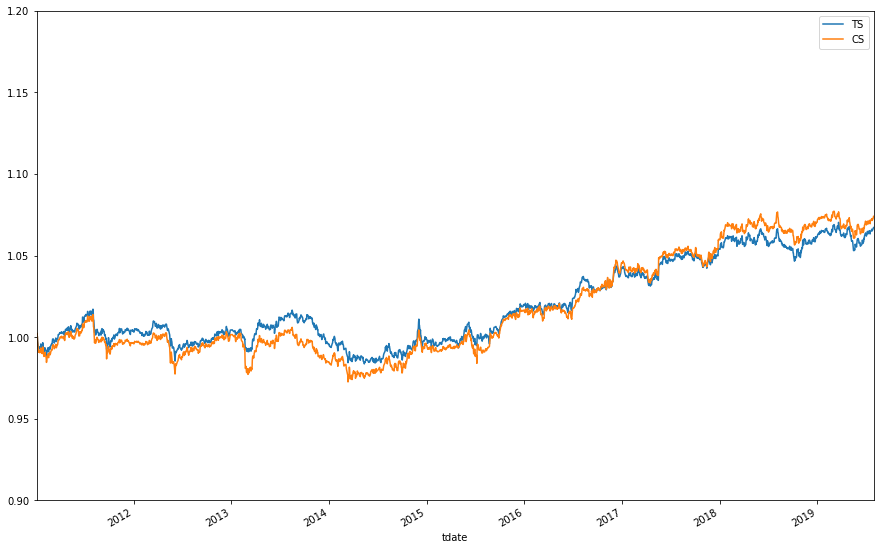

In [35]:
tester = Tester(strategy)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False,  ylim=(0.9, 1.2))

# CASE 2. BINARY 30% 70%


- 상위 30%에 속하는 데이터와 하위 30%에 속하는 데이터로 학습한다.

In [36]:
one_week = 5
one_week = 20

df_index_rank = df_index.pct_change(one_week).shift(-1 * one_week).rank(axis=1) 

df_index_y_binary30_1 = df_index_rank > 7/10 * df_index_rank.shape[1]
df_index_y_binary30_1 = df_index_y_binary30_1.astype(np.float32)

df_index_y_binary30_2 = df_index_rank < 3/10 * df_index_rank.shape[1]
df_index_y_binary30_2 = df_index_y_binary30_2.astype(np.float32)

In [37]:
df_index_y_binary30_1 = df_index_y_binary30_1.unstack().reset_index()
df_index_y_binary30_1.columns = ['ticker', 'tdate', 'info']

df_index_y_binary30_2 = df_index_y_binary30_2.unstack().reset_index()
df_index_y_binary30_2.columns = ['ticker', 'tdate', 'info']

In [38]:
df_index_y_binary30_1 = df_index_y_binary30_1[df_index_y_binary30_1['info'] == 1]
df_index_y_binary30_2 = df_index_y_binary30_2[df_index_y_binary30_2['info'] == 1]
df_index_y_binary30 = pd.concat([df_index_y_binary30_1, df_index_y_binary30_2], axis=0)

In [39]:
df_y2 = df_index_y_binary.unstack().reset_index()
df_y2.columns = ['ticker', 'tdate', 'y']
df_y2 = pd.merge(df_y2, df_index_y_binary30, on=['ticker', 'tdate'])

In [40]:
df_join2 = pd.merge(df_y2, df_moving_avg, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_moving_avg_ratio, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_moving_avg_ratio_diff, on=['tdate', 'ticker'])

In [41]:
df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime('2010-12-31')]
df_val = df_join.loc[(df_join['tdate'] >= pd.to_datetime('2009-01-01')) & (df_join2['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[4:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [42]:
model2, train_pred2, val_pred2 = train(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                    num_boost_round=500, 
                                    learning_rate=0.01, 
                                    verbose=10,
                                    early_stopping_rounds=500)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.690156	valid_1's binary_logloss: 0.693426
[20]	training's binary_logloss: 0.688891	valid_1's binary_logloss: 0.693188
[30]	training's binary_logloss: 0.687778	valid_1's binary_logloss: 0.693078
[40]	training's binary_logloss: 0.686761	valid_1's binary_logloss: 0.693011
[50]	training's binary_logloss: 0.685777	valid_1's binary_logloss: 0.692907
[60]	training's binary_logloss: 0.684912	valid_1's binary_logloss: 0.692936
[70]	training's binary_logloss: 0.684098	valid_1's binary_logloss: 0.692956
[80]	training's binary_logloss: 0.683338	valid_1's binary_logloss: 0.693178
[90]	training's binary_logloss: 0.682573	valid_1's binary_logloss: 0.693349
[100]	training's binary_logloss: 0.681874	valid_1's binary_logloss: 0.693546
[110]	training's binary_logloss: 0.681201	valid_1's binary_logloss: 0.693745
[120]	training's binary_logloss: 0.680614	valid_1's binary_logloss: 0.694133
[130]	training's binary

In [43]:
df_pred2 = df_join.copy()
pred2 = model2.predict(df_join[df_join.columns[3:]].values)
df_pred2['y_pred'] = pred2
df_pred2 = pd.pivot_table(df_pred2, columns='ticker', index='tdate', values='y_pred')

(array([5.000e+00, 2.800e+01, 8.300e+01, 1.650e+02, 1.750e+02, 1.980e+02,
        2.270e+02, 2.190e+02, 1.790e+02, 1.590e+02, 2.530e+02, 4.370e+02,
        1.169e+03, 5.220e+03, 8.150e+03, 9.946e+03, 7.404e+03, 4.550e+03,
        3.158e+03, 2.692e+03, 2.101e+03, 8.580e+02, 4.870e+02, 2.330e+02,
        1.300e+02, 7.800e+01, 5.900e+01, 2.600e+01, 1.700e+01, 1.400e+01]),
 array([0.14642408, 0.17048083, 0.19453758, 0.21859432, 0.24265107,
        0.26670781, 0.29076456, 0.31482131, 0.33887805, 0.3629348 ,
        0.38699154, 0.41104829, 0.43510504, 0.45916178, 0.48321853,
        0.50727527, 0.53133202, 0.55538877, 0.57944551, 0.60350226,
        0.627559  , 0.65161575, 0.6756725 , 0.69972924, 0.72378599,
        0.74784273, 0.77189948, 0.79595623, 0.82001297, 0.84406972,
        0.86812646]),
 <a list of 30 Patch objects>)

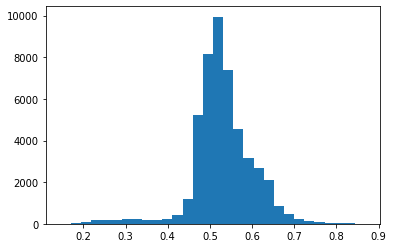

In [44]:
plt.hist(pred2, bins=30)

In [45]:
long = df_pred2.shape[1] / 10 * 7
short = df_pred2.shape[1] / 10 * 3

df_pred_rank2 = df_pred2.rank(axis=1)

df_pred_long2 = (df_pred_rank2 > long).astype(np.float32)
df_pred_short2 = (df_pred_rank2 < short).astype(np.float32)
df_pred_long_short2 = df_pred_long2 - df_pred_short2

In [46]:
strategy2 = EmergingStrategy(strategy_name="EMPM", asset_type="EMERGING")
strategy2.load_index_and_return(from_db=False, save_file=False)

strategy2.index.columns.name = 'ticker'
strategy2.ret.columns.name = 'ticker'

strategy2.index.index.name = 'tdate'
strategy2.ret.index.name = 'tdate'
strategy2.ret.loc['2013-01-02'] = strategy2.ret.loc['2013-01-03']


strategy2.index.drop_duplicates(inplace=True)
strategy2.ret.drop_duplicates(inplace=True)

2019-10-31 09:36:20,140 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:36:20,140 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:36:20,141 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:36:20,141 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:36:20,142 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 09:36:20,142 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [47]:
strategy2.TSRV = df_pred_long_short2
strategy2.CSRV = df_pred_long_short2

strategy2.set_rebalance_period(freq='month', rebalance_weekday=1) 
strategy2.set_portfolio_parameter(cs_strategy_type='notional')
strategy2.make_portfolio()

2019-10-31 09:36:20,168 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:36:20,168 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:36:20,169 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:36:20,169 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:36:20,170 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:36:20,170 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:36:20,170 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:36:20,170 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:36:27,000 - EMPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-31 09:36:27,000 - EMPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-31 09:36:27,001 - EMPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-31 09:36:27,001 - EMPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-31 09:36:28,669 - EMPM - INFO - [STEP 5 - 2 - 2] TARGET VOL CONTROL to TS POSITION
2019-10-31 09:36:28

### TRAIN

2019-10-31 09:36:33,550 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:36:33,550 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:36:33,551 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:36:33,551 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:36:33,558 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-31 09:36:33,558 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-31 09:36:33,564 - EMPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-31 09:36:33,564 - EMPM - INFO - [STEP 7] PLOT BACKTEST RESULT


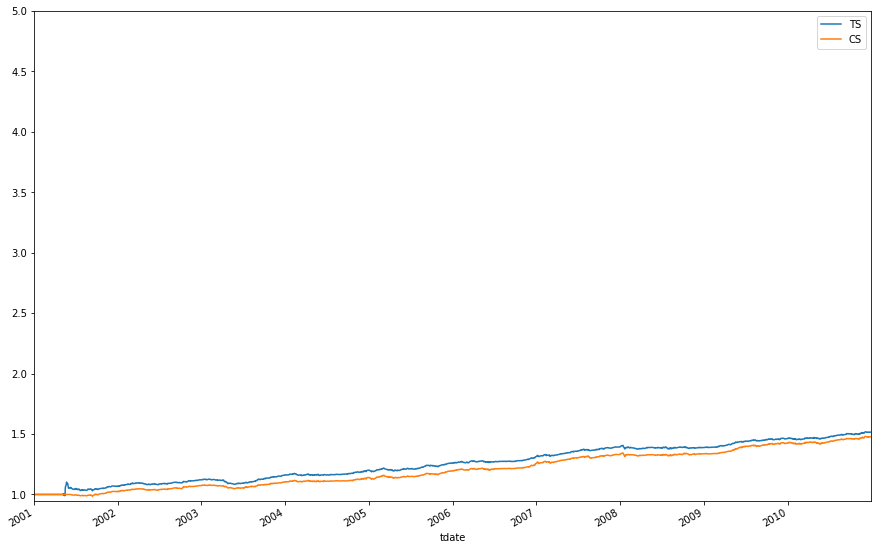

In [48]:
tester = Tester(strategy2)
tester.set_period(start='1994-01-01', end='2010-12-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.95, 5))

### TEST

2019-10-31 09:36:33,720 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:36:33,720 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:36:33,721 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:36:33,721 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:36:33,728 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-31 09:36:33,728 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-31 09:36:33,736 - EMPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-31 09:36:33,736 - EMPM - INFO - [STEP 7] PLOT BACKTEST RESULT


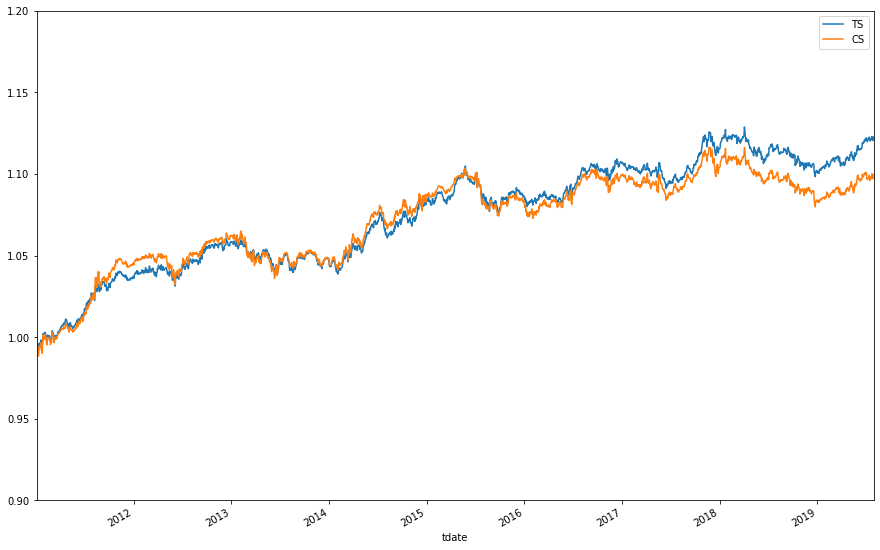

In [49]:
tester = Tester(strategy2)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.9, 1.2))

# CASE 3. Case1을 Rolling으로 실행

In [50]:
rolling_one_year = ['2010-12-31',
                    '2011-12-31',
                    '2012-12-31',
                    '2013-12-31',
                    '2014-12-31',
                    '2015-12-31',
                    '2016-12-31',
                    '2017-12-31',
                    '2018-12-31']

In [51]:
def train(train_x, train_y1, val_x, val_y1, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': 3,
          'num_leaves': 25,
          "learning_rate": learning_rate,
          "feature_fraction": 0.8,
          "subsample": 0.8,
          "verbosity": 1,
          "metric": 'binary_logloss'
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [52]:
models = []
train_preds = []
test_preds = []

In [53]:
for i, one_year in enumerate(rolling_one_year):
    df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime(rolling_one_year[i])]
    
    if i == len(rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(rolling_one_year[i])]
    else:
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, test_pred = train(df_train_x.values, df_train_y.values, df_test_x.values, df_test_y.values, 
                                        num_boost_round=500, 
                                        learning_rate=0.01, 
                                        verbose=10,
                                        early_stopping_rounds=500)
    
    df_train['y_pred'] = train_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    test_preds.append(df_test)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.692394	valid_1's binary_logloss: 0.692455
[20]	training's binary_logloss: 0.691754	valid_1's binary_logloss: 0.692165
[30]	training's binary_logloss: 0.691177	valid_1's binary_logloss: 0.691846
[40]	training's binary_logloss: 0.690668	valid_1's binary_logloss: 0.691591
[50]	training's binary_logloss: 0.690163	valid_1's binary_logloss: 0.691277
[60]	training's binary_logloss: 0.689697	valid_1's binary_logloss: 0.691057
[70]	training's binary_logloss: 0.689246	valid_1's binary_logloss: 0.690843
[80]	training's binary_logloss: 0.688826	valid_1's binary_logloss: 0.690569
[90]	training's binary_logloss: 0.688436	valid_1's binary_logloss: 0.690345
[100]	training's binary_logloss: 0.688055	valid_1's binary_logloss: 0.690206
[110]	training's binary_logloss: 0.687662	valid_1's binary_logloss: 0.689897
[120]	training's binary_logloss: 0.687282	valid_1's binary_logloss: 0.689611
[130]	training's binary

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.692401	valid_1's binary_logloss: 0.692847
[20]	training's binary_logloss: 0.691729	valid_1's binary_logloss: 0.692675
[30]	training's binary_logloss: 0.691125	valid_1's binary_logloss: 0.692546
[40]	training's binary_logloss: 0.690569	valid_1's binary_logloss: 0.692433
[50]	training's binary_logloss: 0.690049	valid_1's binary_logloss: 0.692345
[60]	training's binary_logloss: 0.689574	valid_1's binary_logloss: 0.692225
[70]	training's binary_logloss: 0.689126	valid_1's binary_logloss: 0.692165
[80]	training's binary_logloss: 0.688712	valid_1's binary_logloss: 0.692093
[90]	training's binary_logloss: 0.688325	valid_1's binary_logloss: 0.692068
[100]	training's binary_logloss: 0.687944	valid_1's binary_logloss: 0.692016
[110]	training's binary_logloss: 0.68758	valid_1's binary_logloss: 0.692001
[120]	training's binary_logloss: 0.68724	valid_1's binary_logloss: 0.691955
[130]	training's binary_l

[170]	training's binary_logloss: 0.687125	valid_1's binary_logloss: 0.692097
[180]	training's binary_logloss: 0.686861	valid_1's binary_logloss: 0.692059
[190]	training's binary_logloss: 0.686645	valid_1's binary_logloss: 0.692111
[200]	training's binary_logloss: 0.686444	valid_1's binary_logloss: 0.692259
[210]	training's binary_logloss: 0.686236	valid_1's binary_logloss: 0.692441
[220]	training's binary_logloss: 0.68606	valid_1's binary_logloss: 0.692672
[230]	training's binary_logloss: 0.685877	valid_1's binary_logloss: 0.69292
[240]	training's binary_logloss: 0.685696	valid_1's binary_logloss: 0.693148
[250]	training's binary_logloss: 0.685539	valid_1's binary_logloss: 0.693393
[260]	training's binary_logloss: 0.685356	valid_1's binary_logloss: 0.693535
[270]	training's binary_logloss: 0.685175	valid_1's binary_logloss: 0.693713
[280]	training's binary_logloss: 0.685014	valid_1's binary_logloss: 0.693953
[290]	training's binary_logloss: 0.684849	valid_1's binary_logloss: 0.694144
[

[220]	training's binary_logloss: 0.686768	valid_1's binary_logloss: 0.693319
[230]	training's binary_logloss: 0.686571	valid_1's binary_logloss: 0.69338
[240]	training's binary_logloss: 0.686392	valid_1's binary_logloss: 0.693387
[250]	training's binary_logloss: 0.686213	valid_1's binary_logloss: 0.693496
[260]	training's binary_logloss: 0.686047	valid_1's binary_logloss: 0.693691
[270]	training's binary_logloss: 0.685874	valid_1's binary_logloss: 0.693841
[280]	training's binary_logloss: 0.685729	valid_1's binary_logloss: 0.694027
[290]	training's binary_logloss: 0.685559	valid_1's binary_logloss: 0.694169
[300]	training's binary_logloss: 0.685399	valid_1's binary_logloss: 0.694296
[310]	training's binary_logloss: 0.685242	valid_1's binary_logloss: 0.694329
[320]	training's binary_logloss: 0.685093	valid_1's binary_logloss: 0.694297
[330]	training's binary_logloss: 0.684961	valid_1's binary_logloss: 0.694321
[340]	training's binary_logloss: 0.684814	valid_1's binary_logloss: 0.69436
[

[300]	training's binary_logloss: 0.685625	valid_1's binary_logloss: 0.690671
[310]	training's binary_logloss: 0.68545	valid_1's binary_logloss: 0.69057
[320]	training's binary_logloss: 0.685262	valid_1's binary_logloss: 0.690532
[330]	training's binary_logloss: 0.685098	valid_1's binary_logloss: 0.690417
[340]	training's binary_logloss: 0.684922	valid_1's binary_logloss: 0.690366
[350]	training's binary_logloss: 0.684755	valid_1's binary_logloss: 0.690341
[360]	training's binary_logloss: 0.684571	valid_1's binary_logloss: 0.690318
[370]	training's binary_logloss: 0.684397	valid_1's binary_logloss: 0.690346
[380]	training's binary_logloss: 0.684236	valid_1's binary_logloss: 0.690315
[390]	training's binary_logloss: 0.684067	valid_1's binary_logloss: 0.690286
[400]	training's binary_logloss: 0.683913	valid_1's binary_logloss: 0.690269
[410]	training's binary_logloss: 0.683742	valid_1's binary_logloss: 0.690297
[420]	training's binary_logloss: 0.683586	valid_1's binary_logloss: 0.690275
[

In [54]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

(array([4.000e+00, 2.100e+01, 4.400e+01, 4.100e+01, 3.800e+01, 4.400e+01,
        7.200e+01, 8.100e+01, 1.120e+02, 3.110e+02, 5.280e+02, 1.077e+03,
        2.760e+03, 7.558e+03, 3.730e+03, 2.115e+03, 1.534e+03, 9.630e+02,
        5.540e+02, 3.020e+02, 1.880e+02, 1.120e+02, 6.500e+01, 3.700e+01,
        2.900e+01, 1.500e+01, 1.000e+01, 1.000e+00, 2.000e+00, 2.000e+00]),
 array([0.2086173 , 0.22911381, 0.24961031, 0.27010681, 0.29060332,
        0.31109982, 0.33159633, 0.35209283, 0.37258933, 0.39308584,
        0.41358234, 0.43407885, 0.45457535, 0.47507185, 0.49556836,
        0.51606486, 0.53656137, 0.55705787, 0.57755437, 0.59805088,
        0.61854738, 0.63904389, 0.65954039, 0.68003689, 0.7005334 ,
        0.7210299 , 0.74152641, 0.76202291, 0.78251941, 0.80301592,
        0.82351242]),
 <a list of 30 Patch objects>)

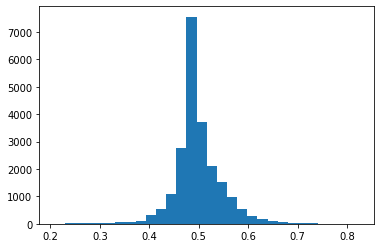

In [55]:
plt.hist(df_test_concat['y_pred'], bins=30)

In [56]:
long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

df_pred_rank3 = df_test_pred.rank(axis=1)
df_pred_long3 = (df_pred_rank3 > long).astype(np.float32)
df_pred_short3 = (df_pred_rank3 < short).astype(np.float32)
df_pred_long_short3 = df_pred_long3 - df_pred_short3

In [57]:
strategy3 = EmergingStrategy(strategy_name="EMPM", asset_type="EMERGING")
strategy3.load_index_and_return(from_db=False, save_file=False)

strategy3.index.columns.name = 'ticker'
strategy3.ret.columns.name = 'ticker'

strategy3.index.index.name = 'tdate'
strategy3.ret.index.name = 'tdate'
strategy3.ret.loc['2013-01-02'] = strategy3.ret.loc['2013-01-03']


strategy3.index.drop_duplicates(inplace=True)
strategy3.ret.drop_duplicates(inplace=True)

2019-10-31 09:36:42,669 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:36:42,669 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:36:42,669 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:36:42,671 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:36:42,671 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:36:42,671 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:36:42,672 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 09:36:42,672 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 09:36:42,672 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [58]:
strategy3.TSRV = df_pred_long_short3
strategy3.CSRV = df_pred_long_short3

strategy3.set_rebalance_period(freq='month', rebalance_weekday=1) 
strategy3.set_portfolio_parameter(cs_strategy_type='notional')
strategy3.make_portfolio()

2019-10-31 09:36:42,702 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:36:42,702 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:36:42,702 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:36:42,704 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:36:42,704 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:36:42,704 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:36:42,705 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:36:42,705 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:36:42,705 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:36:42,706 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:36:42,706 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:36:42,706 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:36:49,590 - EMPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-31 09:36:49,590 - EMPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-31 09:36:

2019-10-31 09:36:52,654 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:36:52,654 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:36:52,654 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:36:52,656 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:36:52,656 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:36:52,656 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:36:52,662 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-31 09:36:52,662 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-31 09:36:52,662 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-31 09:36:52,669 - EMPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-31 09:36:52,669 - EMPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-31 09:36:52,669 - EMPM - INFO - [STEP 7] PLOT BACKTEST RESULT


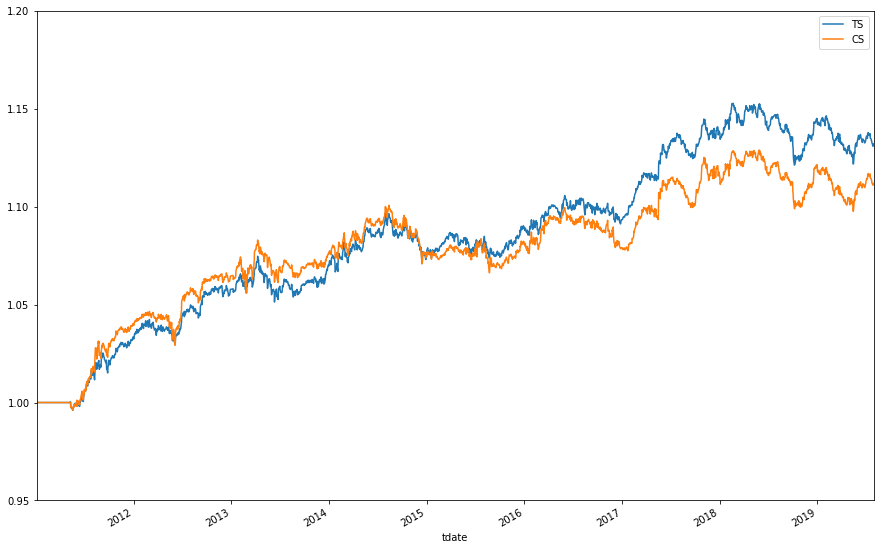

In [59]:
tester = Tester(strategy3)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.95, 1.2))

# CASE 4. CASE 2를 ROLLING으로 실행

In [60]:
models = []
train_preds = []
test_preds = []

In [61]:
for i, one_year in enumerate(rolling_one_year):
    df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime(rolling_one_year[i])]
    
    if i == len(rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(rolling_one_year[i])]
    else:
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, test_pred = train(df_train_x.values, df_train_y.values, df_test_x.values, df_test_y.values, 
                                        num_boost_round=500, 
                                        learning_rate=0.01, 
                                        verbose=10,
                                        early_stopping_rounds=500)
    
    df_train['y_pred'] = train_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    test_preds.append(df_test)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.690156	valid_1's binary_logloss: 0.695198
[20]	training's binary_logloss: 0.688891	valid_1's binary_logloss: 0.695527
[30]	training's binary_logloss: 0.687778	valid_1's binary_logloss: 0.696052
[40]	training's binary_logloss: 0.686761	valid_1's binary_logloss: 0.696704
[50]	training's binary_logloss: 0.685777	valid_1's binary_logloss: 0.696837
[60]	training's binary_logloss: 0.684912	valid_1's binary_logloss: 0.697954
[70]	training's binary_logloss: 0.684098	valid_1's binary_logloss: 0.69827
[80]	training's binary_logloss: 0.683338	valid_1's binary_logloss: 0.699078
[90]	training's binary_logloss: 0.682573	valid_1's binary_logloss: 0.700095
[100]	training's binary_logloss: 0.681874	valid_1's binary_logloss: 0.700916
[110]	training's binary_logloss: 0.681201	valid_1's binary_logloss: 0.702205
[120]	training's binary_logloss: 0.680614	valid_1's binary_logloss: 0.703646
[130]	training's binary_

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.689969	valid_1's binary_logloss: 0.694679
[20]	training's binary_logloss: 0.688749	valid_1's binary_logloss: 0.694775
[30]	training's binary_logloss: 0.687644	valid_1's binary_logloss: 0.695095
[40]	training's binary_logloss: 0.686661	valid_1's binary_logloss: 0.695385
[50]	training's binary_logloss: 0.685725	valid_1's binary_logloss: 0.695686
[60]	training's binary_logloss: 0.684888	valid_1's binary_logloss: 0.695543
[70]	training's binary_logloss: 0.684119	valid_1's binary_logloss: 0.696094
[80]	training's binary_logloss: 0.68336	valid_1's binary_logloss: 0.696441
[90]	training's binary_logloss: 0.682679	valid_1's binary_logloss: 0.696713
[100]	training's binary_logloss: 0.682022	valid_1's binary_logloss: 0.696582
[110]	training's binary_logloss: 0.681389	valid_1's binary_logloss: 0.697122
[120]	training's binary_logloss: 0.680794	valid_1's binary_logloss: 0.697481
[130]	training's binary_

[20]	training's binary_logloss: 0.689193	valid_1's binary_logloss: 0.694723
[30]	training's binary_logloss: 0.68829	valid_1's binary_logloss: 0.694544
[40]	training's binary_logloss: 0.687449	valid_1's binary_logloss: 0.694434
[50]	training's binary_logloss: 0.686649	valid_1's binary_logloss: 0.69416
[60]	training's binary_logloss: 0.685965	valid_1's binary_logloss: 0.694096
[70]	training's binary_logloss: 0.685296	valid_1's binary_logloss: 0.693962
[80]	training's binary_logloss: 0.684684	valid_1's binary_logloss: 0.693902
[90]	training's binary_logloss: 0.684125	valid_1's binary_logloss: 0.693783
[100]	training's binary_logloss: 0.683558	valid_1's binary_logloss: 0.693629
[110]	training's binary_logloss: 0.683048	valid_1's binary_logloss: 0.693691
[120]	training's binary_logloss: 0.682554	valid_1's binary_logloss: 0.6937
[130]	training's binary_logloss: 0.681985	valid_1's binary_logloss: 0.693852
[140]	training's binary_logloss: 0.681409	valid_1's binary_logloss: 0.694199
[150]	train

[130]	training's binary_logloss: 0.682553	valid_1's binary_logloss: 0.697674
[140]	training's binary_logloss: 0.682099	valid_1's binary_logloss: 0.69778
[150]	training's binary_logloss: 0.68162	valid_1's binary_logloss: 0.698236
[160]	training's binary_logloss: 0.68111	valid_1's binary_logloss: 0.698399
[170]	training's binary_logloss: 0.680661	valid_1's binary_logloss: 0.698919
[180]	training's binary_logloss: 0.680227	valid_1's binary_logloss: 0.699632
[190]	training's binary_logloss: 0.679846	valid_1's binary_logloss: 0.700507
[200]	training's binary_logloss: 0.679489	valid_1's binary_logloss: 0.701812
[210]	training's binary_logloss: 0.679098	valid_1's binary_logloss: 0.702355
[220]	training's binary_logloss: 0.678759	valid_1's binary_logloss: 0.703173
[230]	training's binary_logloss: 0.678406	valid_1's binary_logloss: 0.703425
[240]	training's binary_logloss: 0.678008	valid_1's binary_logloss: 0.704001
[250]	training's binary_logloss: 0.677656	valid_1's binary_logloss: 0.704264
[2

[280]	training's binary_logloss: 0.678032	valid_1's binary_logloss: 0.705646
[290]	training's binary_logloss: 0.677698	valid_1's binary_logloss: 0.705925
[300]	training's binary_logloss: 0.677411	valid_1's binary_logloss: 0.706158
[310]	training's binary_logloss: 0.677079	valid_1's binary_logloss: 0.706357
[320]	training's binary_logloss: 0.676772	valid_1's binary_logloss: 0.707055
[330]	training's binary_logloss: 0.676481	valid_1's binary_logloss: 0.707759
[340]	training's binary_logloss: 0.676182	valid_1's binary_logloss: 0.708444
[350]	training's binary_logloss: 0.675883	valid_1's binary_logloss: 0.708923
[360]	training's binary_logloss: 0.67558	valid_1's binary_logloss: 0.709728
[370]	training's binary_logloss: 0.675294	valid_1's binary_logloss: 0.710846
[380]	training's binary_logloss: 0.675038	valid_1's binary_logloss: 0.711898
[390]	training's binary_logloss: 0.674783	valid_1's binary_logloss: 0.712981
[400]	training's binary_logloss: 0.674511	valid_1's binary_logloss: 0.713583


In [62]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

In [63]:
df_pred_rank4 = df_test_pred.rank(axis=1)
df_pred_long4 = (df_pred_rank4 > long).astype(np.float32)
df_pred_short4 = (df_pred_rank4 < short).astype(np.float32)
df_pred_long_short4 = df_pred_long4 - df_pred_short4

In [64]:
strategy4 = EmergingStrategy(strategy_name="EMPM", asset_type="EMERGING")
strategy4.load_index_and_return(from_db=False, save_file=False)

strategy4.index.columns.name = 'ticker'
strategy4.ret.columns.name = 'ticker'

strategy4.index.index.name = 'tdate'
strategy4.ret.index.name = 'tdate'
strategy4.ret.loc['2013-01-02'] = strategy4.ret.loc['2013-01-03']


strategy4.index.drop_duplicates(inplace=True)
strategy4.ret.drop_duplicates(inplace=True)

2019-10-31 09:36:59,750 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:36:59,750 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:36:59,750 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:36:59,750 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:36:59,752 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:36:59,752 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:36:59,752 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:36:59,752 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:36:59,754 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 09:36:59,754 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 09:36:59,754 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 09:36:59,754 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [65]:
strategy4.TSRV = df_pred_long_short4
strategy4.CSRV = df_pred_long_short4

strategy4.set_rebalance_period(freq='month', rebalance_weekday=1) 
strategy4.set_portfolio_parameter(cs_strategy_type='notional')
strategy4.make_portfolio()

2019-10-31 09:36:59,793 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:36:59,793 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:36:59,793 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:36:59,793 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:36:59,795 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:36:59,795 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:36:59,795 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:36:59,795 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:36:59,796 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:36:59,796 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:36:59,796 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:36:59,796 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:36:59,797 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:36:59,797 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:36:59,797 

2019-10-31 09:37:09,787 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:37:09,787 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:37:09,787 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:37:09,787 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:37:09,789 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:37:09,789 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:37:09,789 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:37:09,789 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:37:09,796 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-31 09:37:09,796 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-31 09:37:09,796 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-31 09:37:09,796 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-31 09:37:09,803 - EMPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-31 09:37:09,803 - 

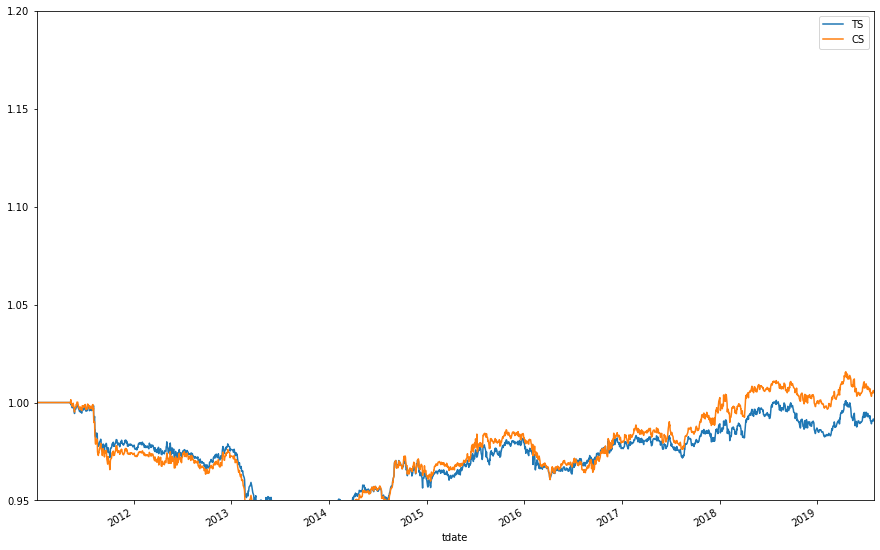

In [66]:
tester = Tester(strategy4)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.95, 1.2))